[View in Colaboratory](https://colab.research.google.com/github/redcican/Machine-Learning-Basic/blob/master/02_Text_Classification_with_movie_reviews.ipynb)

This notebook classifiers movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary* - or two-class-classification, an important and widely applicable kind of machine learning problem.

We will use the **IMDB dataset** that contains the text of 50,000 movie reviews from the internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning contain an equal number of positive and negative reviews.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.9.0


## 1. Download the IMDB dataset

The IMDB dataset comes packaged with TF. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequence of integers, where each integer represents a specific word in a dictionary.

In [2]:
imdb = keras.datasets.imdb

(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 4s 0us/step


The argument `num_words=10000` keeps the top 10,000 most frequently occuring words in the training data. The rare words are discarded to keep the size of the data manageable.

## 2. Explore the data

The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data),len(train_labels)))

Training entries: 25000, labels: 25000


The text of reviews have been converted to integers, where each  integer represents a specific word n a dictionary, here's what the first review looks like:

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. Since inputs to a neural network must be the same length, it need to be resolved later.

In [8]:
print("Length of first: {}, length of second: {}".format(len(train_data[0]), len(train_data[1])))

Length of first: 218, length of second: 189


### 2.1 Convert the integers back to words

Create a helper function to query a dictionary object that contains the integer to string mapping.

In [9]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()


# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2 # unknown
word_index["UNUSED"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 2s 1us/step


In [10]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 3. Prepare the data

The reviews - the arrays of integers must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

* One-hot-encode the array to convert them into vectors of 0s and 1s. For example, the sequence [3,5] would become a 10,000-dimensional vector that is all zeros for indices 3 and 5, which are ones. Then make this the first layer in our network - a Dense layer - that can handle floating point vector data. This approach is memory intensive, though, requiring a `num_words * num_reviews` size matrix

* Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape `num_examples * max_length`. We can use an embedding layer capable of handling this shape as the first layer in our network.



We will use the second apporach, since the movie reviews must be the same length, we will use the ` pad_sequences` function to standardize the lenghts.

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [12]:
print("Length of first: {}, length of second: {}".format(len(train_data[0]), len(train_data[1])))

Length of first: 256, length of second: 256


In [13]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 4. Build the model

The neural network is created by stacking layers - this requires two main architectural decisions:

* How many layers to use in the model?

* How many hidden layer units to use for each layer?

In [14]:
# input shape is the vocabulary count used of the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier.



1.   The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the ouput array. The resulting dimesions are . `(batch, sequence, embedding)`
2.   Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model can handle input of variable length, in the simplest way possible.



In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(),
             loss='binary_crossentropy',
             metrics = ['accuracy'])

## 5. Create a Validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a vaidatoin set by setting apart 10,000 examples from the original training data.

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [0]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val,y_val),
                   verbose=1)

## 6. Evaluate the model

In [18]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 45us/step
[0.30717779620170593, 0.87432]


## 7. Trach the training history

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

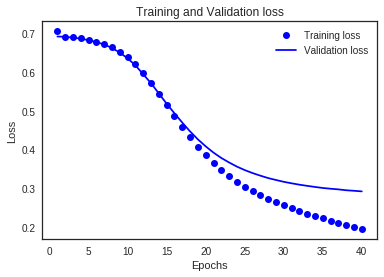

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo',label='Training loss')
plt.plot(epochs, val_loss, 'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

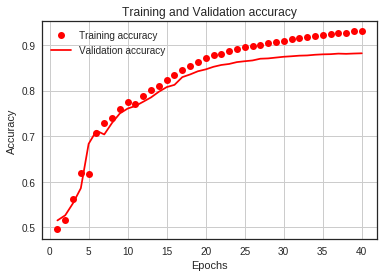

In [26]:
plt.plot(epochs, acc, 'ro',label='Training accuracy')
plt.plot(epochs, val_acc, 'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('On')
plt.show()